In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Importing the libraries

In [126]:
import pandas as pd
import numpy as np
from scipy import fftpack
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()
from PIL import Image
import cv2
import pickle
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import random
from numpy import asarray
from scipy.signal import stft
from sklearn import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
df_nose=pd.read_csv('/content/drive/MyDrive/fourier/nose_tran_400.csv',header=None)
df_et=pd.read_csv('/content/drive/MyDrive/fourier/ETdata_400.csv',header=None)
def plot_history(history, name):
    with plt.xkcd(scale=0.2):
      fig, ax = plt.subplots(1,2, figsize=(12,6))
      for i, metric in enumerate(['loss', 'accuracy']): 
          ax[i].plot(history.history[metric], label='Train', color='#EFAEA4',linewidth=3)
          ax[i].plot(history.history[f'val_{metric}'], label='Validation', color='#B2D7D0',linewidth=3)
          if metric == 'accuracy': 
            ax[i].axhline(0.5, color='#8d021f', ls='--', label='Trivial accuracy')
            ax[i].set_ylabel("Accuracy", fontsize=14)
          else:
            ax[i].set_ylabel("Loss", fontsize=14)
          ax[i].set_xlabel('Epoch', fontsize=14)

      plt.suptitle(f'{name} Training', y=1.05, fontsize=16)
      plt.legend(loc='best')
      plt.tight_layout()

Importing the required data and combining both the datasets.

In [3]:
df_comb=pd.concat([df_nose, df_et], join='inner', axis=1)

# Short Term Fourier Transform
Short-Time Fourier Transform (STFT) is a widely used signal processing technique for analyzing the frequency content of a time-varying signal. STFT works by breaking down a signal into short segments, typically overlapping, and applying the Fourier Transform to each segment to obtain a time-varying spectrum.

STFT is commonly used in a wide range of applications such as speech processing, music analysis, and image processing. In speech processing, STFT is used to analyze the frequency content of a speech signal over time, which is useful for applications such as speech recognition, speaker identification, and speech enhancement. In music analysis, STFT is used to extract features from an audio signal such as tempo, rhythm, and melody. In image processing, STFT is used to analyze the frequency content of an image in different scales and orientations, which is useful for applications such as texture analysis and image denoising.

In [4]:
for i in range(400):
  comb=df_comb.iloc[i,:].to_numpy()
  nose=df_nose.iloc[i,:].to_numpy()
  tongue=df_et.iloc[i,:].to_numpy()
  
  comb_stan=(comb - np.mean(comb)) / np.std(comb) 
  nose_stan=(nose - np.mean(nose)) / np.std(nose) 
  tongue_stan=(tongue - np.mean(tongue)) / np.std(tongue) 


# Define the window length and overlap for the STFT
  window_length = 25
  overlap = 10

# Compute the STFT using the scipy library
  f, t, Zxx = stft(comb_stan, window='hann', nperseg=window_length, noverlap=overlap)

# Plot the resulting spectrogram
  plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=np.max(np.abs(Zxx)))
  st=str(i)
  sav=st+'c.png'
  plt.savefig(sav)
  plt.clf()
  
  f, t, Zxx = stft(nose_stan, window='hann', nperseg=window_length, noverlap=overlap)

# Plot the resulting spectrogram
  plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=np.max(np.abs(Zxx)))
  st=str(i)
  sav=st+'n.png'
  plt.savefig(sav)
  plt.clf()

  
  f, t, Zxx = stft(tongue_stan, window='hann', nperseg=window_length, noverlap=overlap)

# Plot the resulting spectrogram
  plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=np.max(np.abs(Zxx)))
  st=str(i)
  sav=st+'t.png'
  plt.savefig(sav)
  plt.clf()



<Figure size 432x288 with 0 Axes>

We have made 3 kinds of fourier transforms, 
A) Only e_nose data
B) Only e_tongue data
C) Both e_nose and tongue data



In [5]:
arr=np.array([1,0,0,0]*100)
arr2=np.array([0,1,0,0]*100)
arr3=np.array([0,0,1,0]*100)
arr4=np.array([0,0,0,1]*100)
y=np.vstack((arr,arr2,arr3,arr4)).reshape(400,4)

# A)Nose signal 
We will convert the images to an array and use them in Conv2D model for classification.

In [6]:
k=asarray(Image.open('0n.png'))
for i in range(1,400):
  st=str(i)+'n.png'
  img = Image.open(st)
  numpydata = asarray(img)
  k=np.vstack((k,numpydata))


In [7]:
x=k.reshape(400,288,432,4)

In [8]:
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
model_nose = models.Sequential()
model_nose.add(layers.Conv2D(4, (2, 2), activation='relu', input_shape=(288,432,4)))
model_nose.add(layers.MaxPooling2D((2, 2)))
model_nose.add(layers.Conv2D(8, (2, 2), activation='relu'))
model_nose.add(layers.MaxPooling2D((2, 2)))
model_nose.add(layers.Conv2D(16, (2, 2), activation='relu'))
model_nose.add(layers.Flatten())
model_nose.add(layers.Dense(4, activation='softmax'))
model_nose.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_nose.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 287, 431, 4)       68        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 214, 8)       136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 71, 107, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 70, 106, 16)       528       
                                                                 
 flatten (Flatten)           (None, 118720)            0

In [10]:
history_nose=model_nose.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=10)

Epoch 1/20
32/32 [==============================] - 11s 22ms/step - loss: 2358.0884 - accuracy: 0.2875 - val_loss: 657.9716 - val_accuracy: 0.3250
Epoch 2/20
32/32 [==============================] - 0s 11ms/step - loss: 507.1486 - accuracy: 0.2500 - val_loss: 131.4692 - val_accuracy: 0.2250
Epoch 3/20
32/32 [==============================] - 0s 10ms/step - loss: 211.2247 - accuracy: 0.2250 - val_loss: 85.4688 - val_accuracy: 0.5500
Epoch 4/20
32/32 [==============================] - 0s 10ms/step - loss: 91.8258 - accuracy: 0.3375 - val_loss: 33.0878 - val_accuracy: 0.2250
Epoch 5/20
32/32 [==============================] - 0s 11ms/step - loss: 26.7374 - accuracy: 0.3781 - val_loss: 13.2357 - val_accuracy: 0.5500
Epoch 6/20
32/32 [==============================] - 0s 11ms/step - loss: 11.9085 - accuracy: 0.5625 - val_loss: 5.6837 - val_accuracy: 0.5500
Epoch 7/20
32/32 [==============================] - 0s 10ms/step - loss: 1.7621 - accuracy: 0.8344 - val_loss: 7.1280 - val_accuracy: 0.

In [11]:
results_nose = model_nose.evaluate(X_test, y_test, batch_size=10)
print("test loss, test acc:", results_nose)

8/8 [==============================] - 0s 6ms/step - loss: 0.0949 - accuracy: 0.9625
test loss, test acc: [0.09485043585300446, 0.9624999761581421]


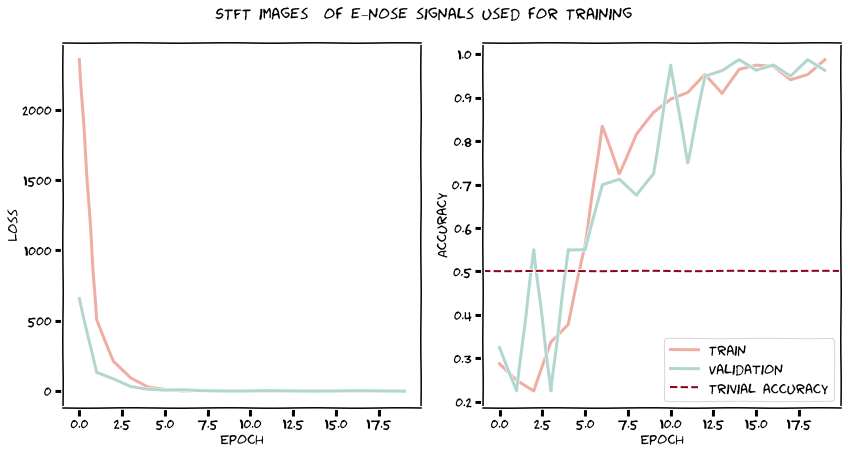

In [12]:
plot_history(history_nose, 'STFT images  of e_nose signals used for')

# Inference
A high level of accuracy has been achieved although the training process is not stable.

# B)Tongue data
We will convert the e_tounge stft images to array and use them for classification

In [13]:
k=asarray(Image.open('0t.png'))
for i in range(1,400):
  st=str(i)+'t.png'
  img = Image.open(st)
  numpydata = asarray(img)
  k=np.vstack((k,numpydata))
x=k.reshape(400,288,432,4)
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)


In [14]:
model_ton = models.Sequential()
model_ton.add(layers.Conv2D(4, (2, 2), activation='relu', input_shape=(288,432,4)))
model_ton.add(layers.MaxPooling2D((2, 2)))
model_ton.add(layers.Conv2D(8, (2, 2), activation='relu'))
model_ton.add(layers.MaxPooling2D((2, 2)))
model_ton.add(layers.Conv2D(16, (2, 2), activation='relu'))
model_ton.add(layers.Flatten())
model_ton.add(layers.Dense(4, activation='softmax'))
model_ton.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ton.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 287, 431, 4)       68        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 143, 215, 4)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 142, 214, 8)       136       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 71, 107, 8)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 70, 106, 16)       528       
                                                                 
 flatten_1 (Flatten)         (None, 118720)           

In [15]:
history_ton_com=model_ton.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=10)

Epoch 1/20
32/32 [==============================] - 2s 21ms/step - loss: 1419.7148 - accuracy: 0.2375 - val_loss: 115.1976 - val_accuracy: 0.3250
Epoch 2/20
32/32 [==============================] - 0s 15ms/step - loss: 50.5290 - accuracy: 0.2562 - val_loss: 4.7911 - val_accuracy: 0.4500
Epoch 3/20
32/32 [==============================] - 0s 15ms/step - loss: 2.6574 - accuracy: 0.4344 - val_loss: 1.0164 - val_accuracy: 0.7750
Epoch 4/20
32/32 [==============================] - 0s 13ms/step - loss: 0.8866 - accuracy: 0.5906 - val_loss: 0.7541 - val_accuracy: 0.6125
Epoch 5/20
32/32 [==============================] - 0s 14ms/step - loss: 0.9398 - accuracy: 0.6531 - val_loss: 1.1489 - val_accuracy: 0.4625
Epoch 6/20
32/32 [==============================] - 0s 13ms/step - loss: 1.2470 - accuracy: 0.4906 - val_loss: 0.5361 - val_accuracy: 0.7750
Epoch 7/20
32/32 [==============================] - 0s 12ms/step - loss: 0.9521 - accuracy: 0.5562 - val_loss: 0.6636 - val_accuracy: 0.7750
Epoch 8

In [16]:
results_tongue = model_ton.evaluate(X_test, y_test, batch_size=10)
print("test loss, test acc:", results_tongue)

8/8 [==============================] - 0s 6ms/step - loss: 0.2299 - accuracy: 0.9000
test loss, test acc: [0.2299308329820633, 0.8999999761581421]


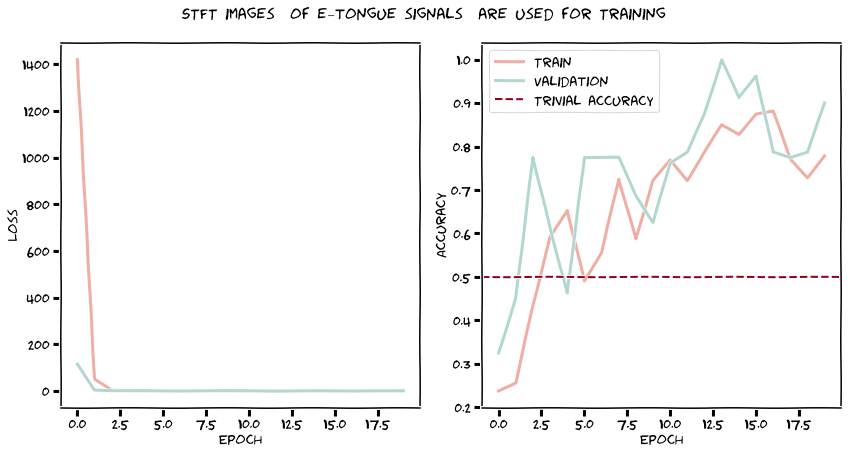

In [17]:
plot_history(history_ton_com, 'STFT images  of e_tongue signals  are used for')

# Inference
This time the training process is not stable and accuracy is quite low.

# C)Combined signal
We will use stft transformed images of combined signals and use them for classification. Just like both of our sense organs work better together , we can assume that both the e_signals will also work better in unison.

In [18]:
k=asarray(Image.open('0c.png'))
for i in range(1,400):
  st=str(i)+'c.png'
  img = Image.open(st)
  numpydata = asarray(img)
  k=np.vstack((k,numpydata))

In [35]:
k=asarray(Image.open('0c.png'))

In [36]:
k.shape

(288, 432, 4)

In [19]:
x=k.reshape(400,288,432,4)

In [20]:
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [24]:
model_com = models.Sequential()
model_com.add(layers.Conv2D(4, (2, 2), activation='relu', input_shape=(288,432,4)))
model_com.add(layers.MaxPooling2D((2, 2)))
model_com.add(layers.Conv2D(8, (2, 2), activation='relu'))
model_com.add(layers.MaxPooling2D((2, 2)))
model_com.add(layers.Conv2D(16, (2, 2), activation='relu'))
model_com.add(layers.Flatten())
model_com.add(layers.Dense(4, activation='softmax'))

In [25]:
model_com.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_com.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 287, 431, 4)       68        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 143, 215, 4)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 142, 214, 8)       136       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 71, 107, 8)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 70, 106, 16)       528       
                                                                 
 flatten_3 (Flatten)         (None, 118720)           

In [26]:
history_com=model_com.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50, batch_size=20)

Epoch 1/50
16/16 [==============================] - 3s 37ms/step - loss: 678.0742 - accuracy: 0.2812 - val_loss: 167.9043 - val_accuracy: 0.2250
Epoch 2/50
16/16 [==============================] - 0s 22ms/step - loss: 73.3429 - accuracy: 0.2906 - val_loss: 19.1360 - val_accuracy: 0.2250
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 13.5776 - accuracy: 0.2688 - val_loss: 5.3261 - val_accuracy: 0.2250
Epoch 4/50
16/16 [==============================] - 0s 21ms/step - loss: 3.5933 - accuracy: 0.2875 - val_loss: 2.9707 - val_accuracy: 0.2250
Epoch 5/50
16/16 [==============================] - 0s 21ms/step - loss: 2.2641 - accuracy: 0.4094 - val_loss: 1.6251 - val_accuracy: 0.4750
Epoch 6/50
16/16 [==============================] - 0s 23ms/step - loss: 2.1603 - accuracy: 0.3125 - val_loss: 1.0389 - val_accuracy: 0.5500
Epoch 7/50
16/16 [==============================] - 0s 23ms/step - loss: 1.0383 - accuracy: 0.5094 - val_loss: 0.8532 - val_accuracy: 0.5250
Epoch 

In [27]:
results_com = model_com.evaluate(X_test, y_test, batch_size=10)
print("test loss, test acc:", results_com)

8/8 [==============================] - 0s 8ms/step - loss: 0.0204 - accuracy: 1.0000
test loss, test acc: [0.020446915179491043, 1.0]


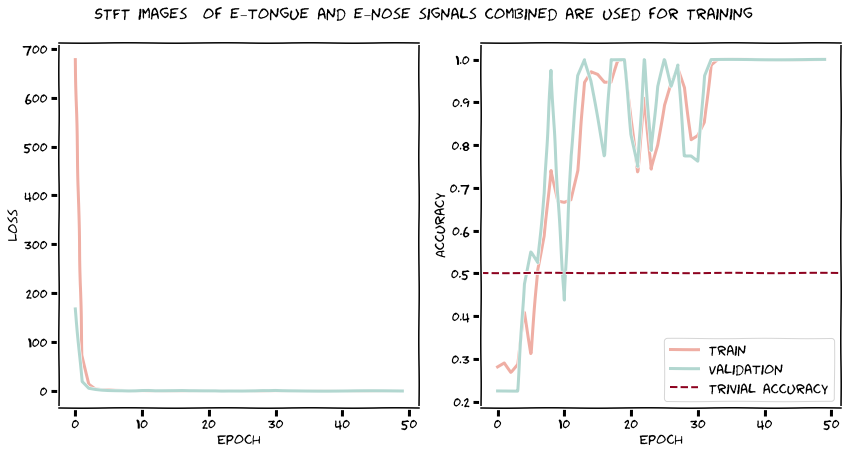

In [28]:
plot_history(history_com, 'STFT images  of e_tongue and e_nose signals combined are used for')

# Inference and conclusion
We can see that the accuracy has nearly reached 100 perc and the training is also near about stable. Using both the signals together therefore work better than using one of them, Below is a comparison of the accuracies.

# Final accuracy comparison

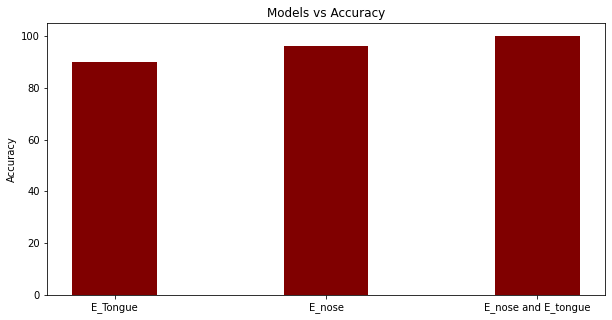

In [29]:
data = {'E_Tongue':results_tongue[1]*100, 'E_nose':results_nose[1]*100, 'E_nose and E_tongue':results_com[1]*100}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
#plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Models vs Accuracy")
plt.show()

# Feature Engineering
We are using saliency maps on the e_nose model to get an idea of how the model is focussing on the fourier transformed images.We can later use this idea to find important parts in signals to identify and classify.

In [127]:
dict_pred={0:'Class-A',1:'Class-B',2:'Class-C',3:'Class-D'}

In [128]:

img_path = '/content/50n.png'
img = Image.open(img_path)
x = asarray(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = tf.convert_to_tensor(x)
preds1=np.argmax(model_nose.predict(x))


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


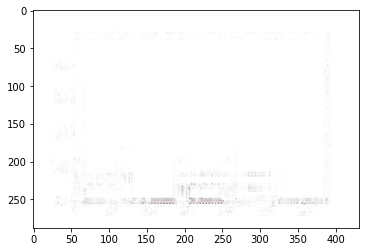

This is predicted Class-A


In [129]:
preds = model_nose.predict(x)
pred_class = np.argmax(preds[0])
output_tensor = model_nose.output[:, pred_class]
with tf.GradientTape() as tape:
    tape.watch(x)
    output = model_nose(x)
    loss = output[:, pred_class]
grads = tape.gradient(loss, x)
grads = tf.math.abs(grads)
max_grads = np.max(grads)
grads /= max_grads
grads = tf.reshape(grads, (288, 432,4))
grads = grads.numpy()

# Display the saliency map
plt.imshow(grads, cmap='gray')
plt.show()
print("This is predicted "+dict_pred[preds1])

In [130]:
img_path = '/content/150n.png'
img = Image.open(img_path)
x = asarray(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = tf.convert_to_tensor(x)
preds1=np.argmax(model_nose.predict(x))

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


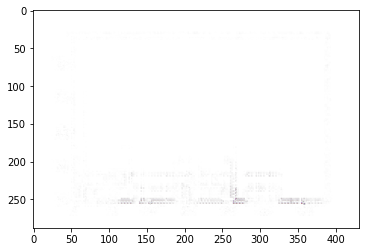

This is predicted Class-B


In [131]:
preds = model_nose.predict(x)
pred_class = np.argmax(preds[0])
output_tensor = model_nose.output[:, pred_class]
with tf.GradientTape() as tape:
    tape.watch(x)
    output = model_nose(x)
    loss = output[:, pred_class]
grads = tape.gradient(loss, x)
grads = tf.math.abs(grads)
max_grads = np.max(grads)
grads /= max_grads
grads = tf.reshape(grads, (288, 432,4))
grads = grads.numpy()

# Display the saliency map
plt.imshow(grads, cmap='gray')
plt.show()
print("This is predicted "+dict_pred[preds1])

In [132]:
img_path = '/content/250n.png'
img = Image.open(img_path)
x = asarray(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = tf.convert_to_tensor(x)
preds1=np.argmax(model_nose.predict(x))

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 33ms/step


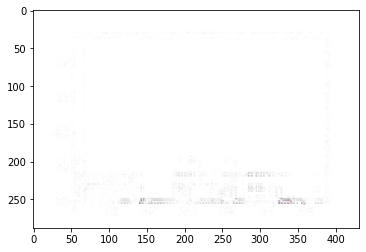

This is predicted Class-C


In [133]:
preds = model_nose.predict(x)
pred_class = np.argmax(preds[0])
output_tensor = model_nose.output[:, pred_class]
with tf.GradientTape() as tape:
    tape.watch(x)
    output = model_nose(x)
    loss = output[:, pred_class]
grads = tape.gradient(loss, x)
grads = tf.math.abs(grads)
max_grads = np.max(grads)
grads /= max_grads
grads = tf.reshape(grads, (288, 432,4))
grads = grads.numpy()

# Display the saliency map
plt.imshow(grads, cmap='gray')
plt.show()
print("This is predicted "+dict_pred[preds1])

In [134]:
img_path = '/content/350n.png'
img = Image.open(img_path)
x = asarray(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = tf.convert_to_tensor(x)
preds1=np.argmax(model_nose.predict(x))

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 64ms/step


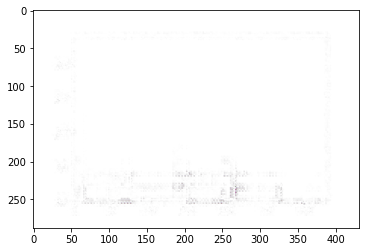

This is predicted Class-D


In [135]:
preds = model_nose.predict(x)
pred_class = np.argmax(preds[0])
output_tensor = model_nose.output[:, pred_class]
with tf.GradientTape() as tape:
    tape.watch(x)
    output = model_nose(x)
    loss = output[:, pred_class]
grads = tape.gradient(loss, x)
grads = tf.math.abs(grads)
max_grads = np.max(grads)
grads /= max_grads
grads = tf.reshape(grads, (288, 432,4))
grads = grads.numpy()

# Display the saliency map
plt.imshow(grads, cmap='gray')
plt.show()
print("This is predicted "+dict_pred[preds1])